In [3]:
%%capture

# Instalar transformers y graphviz
!sudo apt-get install graphviz graphviz-dev
!pip install transformers pygraphviz

# Asegurarse de que se utilice UTF-8 como codificación
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Establecer una semilla para la generación de números aleatorios en PyTorch
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
#Configuración inicial
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

#Seleccionar el dispositivo: 'cuda' (GPU) si está disponible, de lo contrario, 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Cargar un modelo GPT-2 y su tokenizador
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

# Definir un texto de inicio para la generación
text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

# Generar texto utilizando Greedy Search
outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text: I have a dream of being a doctor.


In [5]:
# Importar librerías necesarias
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

# Función para obtener el logaritmo de la probabilidad de un token
def get_log_prob(logits, token_id):
    # Calcular la función softmax de los logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)

    # Obtener el logaritmo de la probabilidad del token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

# Función para realizar la búsqueda Greedy
def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Obtener el sub-token siguiente predicho (aquí utilizamos Top-K Search)
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    # Calcular la puntuación del token predicho
    token_score = get_log_prob(logits, token_id)

    # Agregar el token predicho a la lista de IDs de entrada
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Agregar nodo y arista al grafo
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Llamada recursiva
    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

# Parámetros
length = 5
beams = 1

# Crear un árbol balanceado con altura 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Agregar atributos 'tokenscore', 'cumscore' y 'token' a cada nodo
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# Comenzar la generación de texto con Greedy Search
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: I have a dream of being a doctor.


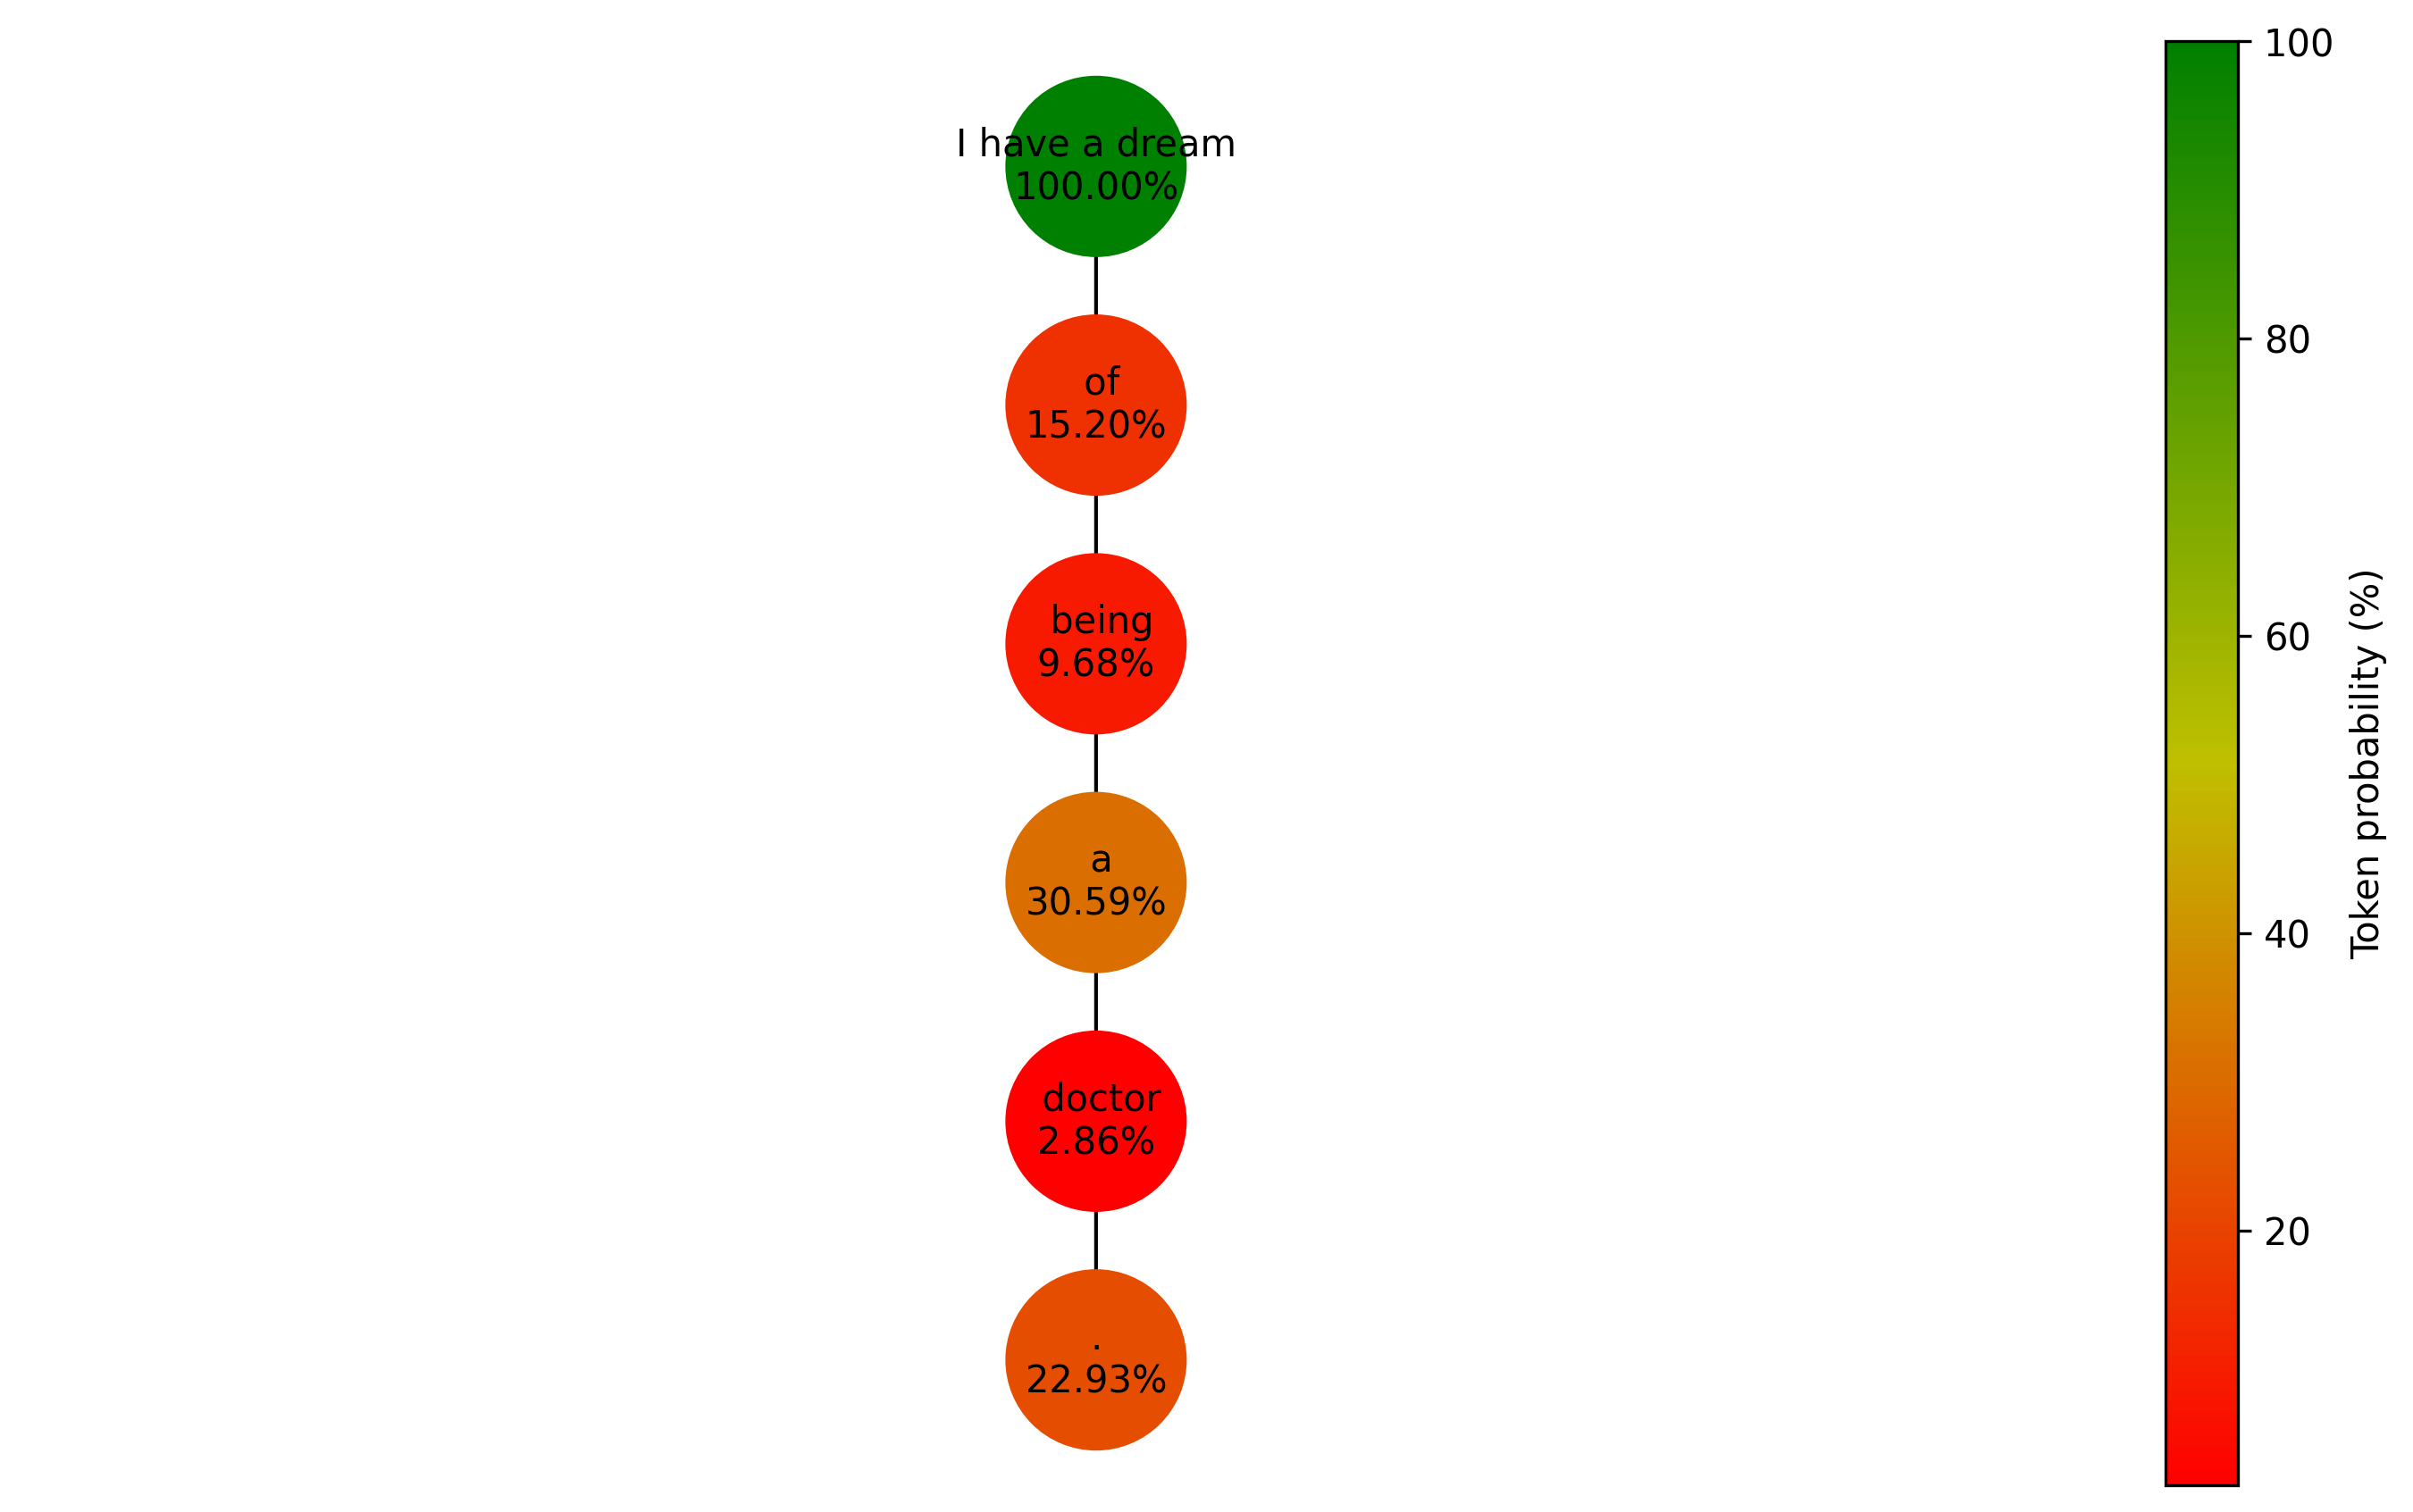

In [6]:
# Importar librerías para visualización del grafo
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Función para graficar el grafo
def plot_graph(graph, length, beams, score):
    # Crear una figura y ejes para el gráfico
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Crear posiciones para cada nodo en el gráfico
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalizar los colores a lo largo del rango de puntuaciones de tokens
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

     # Dibujar los nodos en el gráfico
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4,
                          node_color=scores, cmap=cmap)

    # Dibujar las aristas (conexiones entre nodos)
    nx.draw_networkx_edges(graph, pos)

    # Dibujar las etiquetas de los nodos
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    # Eliminar el borde alrededor del gráfico
    plt.box(False)

     # Agregar una barra de colores
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    # Mostrar el gráfico
    plt.show()

# Llamar a la función plot_graph con los argumentos correspondientes
plot_graph(graph, length, 1.5, 'token')

In [7]:
#beam search
# Importación de la biblioteca tqdm para mostrar una barra de progreso
from tqdm.notebook import tqdm

# Función para realizar muestreo avaro (greedy sampling) de los logits
def greedy_sampling(logits, beams):
    # Devuelve los índices de los 'beams' principales según los logits
    return torch.topk(logits, beams).indices

# Función principal para la búsqueda con beam search
def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    # Caso base: si se ha alcanzado la longitud deseada, se retorna None
    if length == 0:
        return None

    # Obtener las predicciones del modelo para las entradas actuales
    outputs = model(input_ids)
    predictions = outputs.logits

    # Obtener los logits de la próxima sub-palabra predicha (usamos top-k search)
    logits = predictions[0, -1, :]

    # Dependiendo del método de muestreo especificado (greedy, top_k o nucleus),
    # obtenemos los 'beams' principales
    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    # Para cada uno de los 'beams' principales
    for j, token_id in enumerate(top_token_ids):
      # Actualizamos la barra de progreso
        bar.update(1)

         # Calculamos la puntuación del token predicho
        token_score = get_log_prob(logits, token_id)
        # Calculamos la puntuación acumulativa para esta rama del grafo
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Concatenamos el token predicho a las entradas actuales
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Agregamos un nodo y una arista al grafo
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

         # Llamada recursiva para explorar esta rama del grafo
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

# Parámetros de la búsqueda con beam search
length = 5 # Longitud deseada del texto generado
beams = 2 # Número de 'beams' para explorar

# Crear un árbol equilibrado con altura 'length' y factor de ramificación 'beams'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Agregar atributos 'tokenscore', 'cumscore' y 'token' a cada nodo del grafo
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100# Puntuación inicial para cada nodo
    graph.nodes[node]['cumscore'] = 0 # Puntuación acumulada (se actualizará durante la búsqueda)
    graph.nodes[node]['sequencescore'] = 0 # Puntuación de la secuencia (se actualizará durante la búsqueda)
    graph.nodes[node]['token'] = text # El texto inicial es el mismo para todos los nodos

# Comenzar a generar texto utilizando la búsqueda con beam search
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)

  0%|          | 0/63 [00:00<?, ?it/s]

In [8]:
# Función para obtener la mejor secuencia en el grafo 'G'
def get_best_sequence(G):
    # Crear una lista de nodos hoja
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

     # Obtener el nodo hoja con la puntuación cumscore más alta
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

   # Recuperar la secuencia de nodos desde este nodo hoja hasta el nodo raíz en una lista
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Devolver la cadena de atributos de token de esta secuencia
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])

    return sequence, max_score

# Obtener la mejor secuencia del grafo generado
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


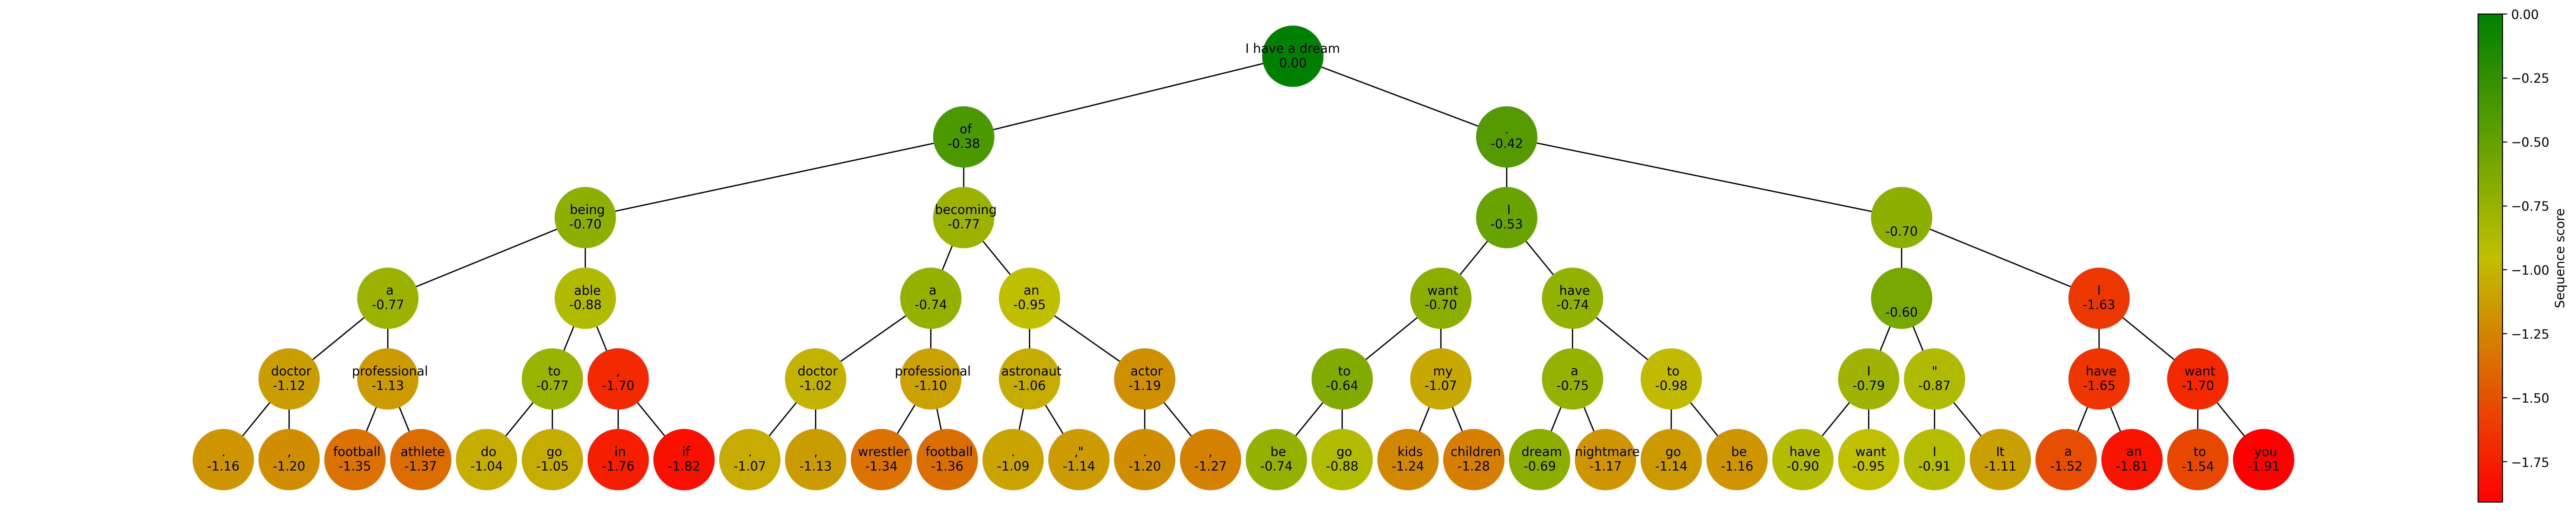

In [9]:
# Graficar el grafo
plot_graph(graph, length, beams, 'sequence')

In [10]:
#Top-k sampling
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    # Obtener los mejores k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

     # Obtener los próximos tokens y sus probabilidades
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Crear una figura
    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()

def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convertir logits a probabilidades
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Muestrear n tokens de la distribución resultante
    next_tokens = torch.multinomial(probabilities, beams)

    # Graficar la distribución
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

# Comenzar a generar texto con búsqueda 'top_k'
beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)

In [11]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I am going to


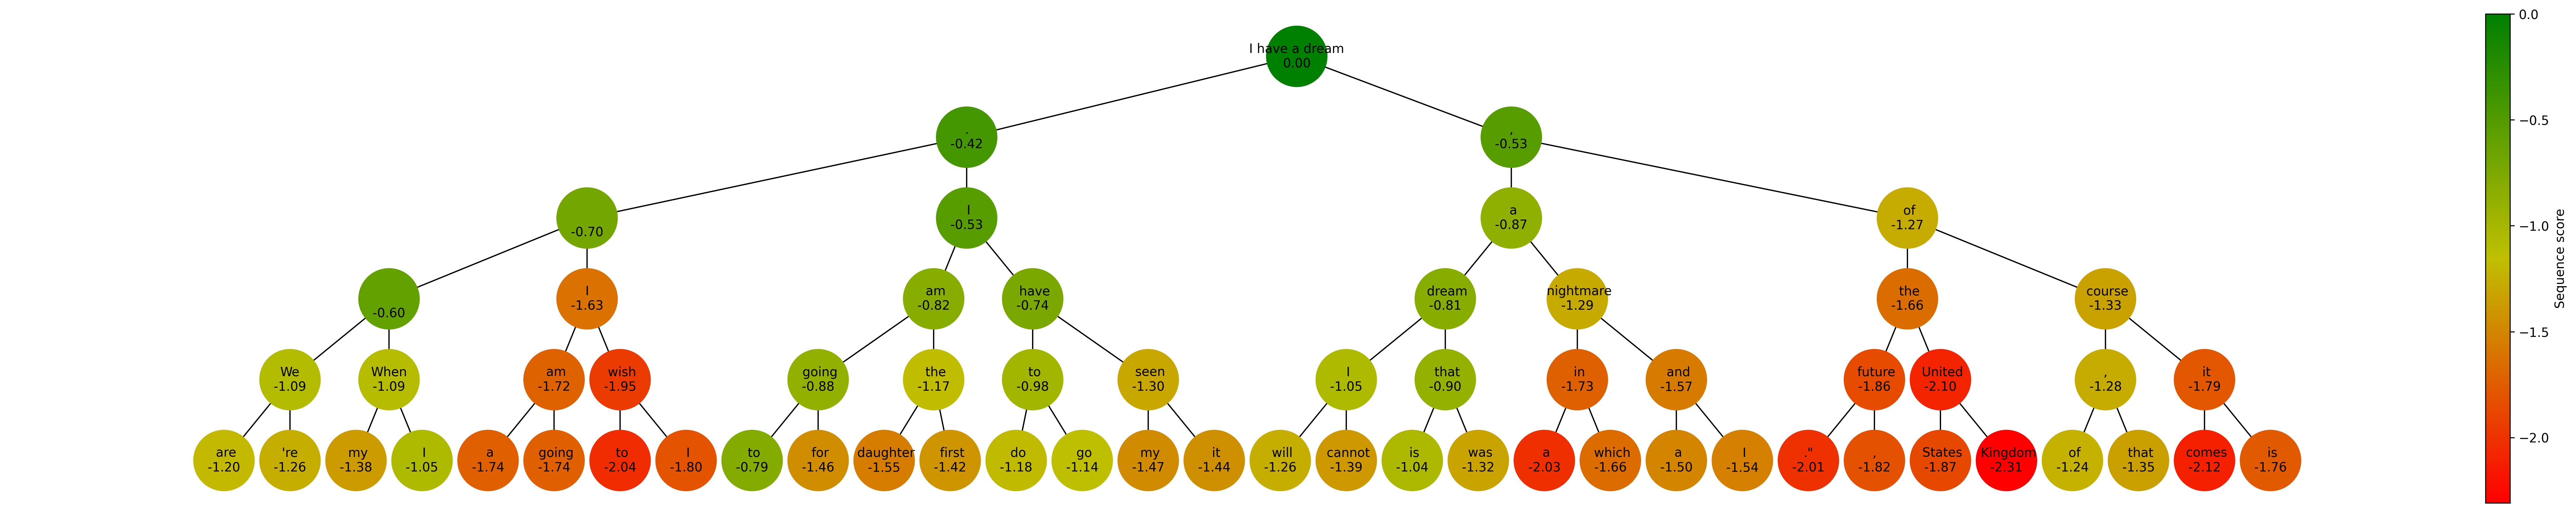

In [12]:
# Gráfico
plot_graph(graph, length, beams, 'sequence')

In [13]:
#nucleus sampling
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Ordenar las probabilidades en orden descendente y calcular las probabilidades acumulativas
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

     # Crear una máscara para las probabilidades que se encuentran en el top-p
    mask = cumulative_probabilities < p

    # Si no hay un índice donde cumulative_probabilities < p, utilizamos en su lugar los mejores n tokens
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Mantener solo los índices top-p
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    # Muestrear n tokens de la distribución resultante
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    # Graficar la distribución
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

# # Comenzar a generar texto con búsqueda 'núcleo'
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

In [14]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


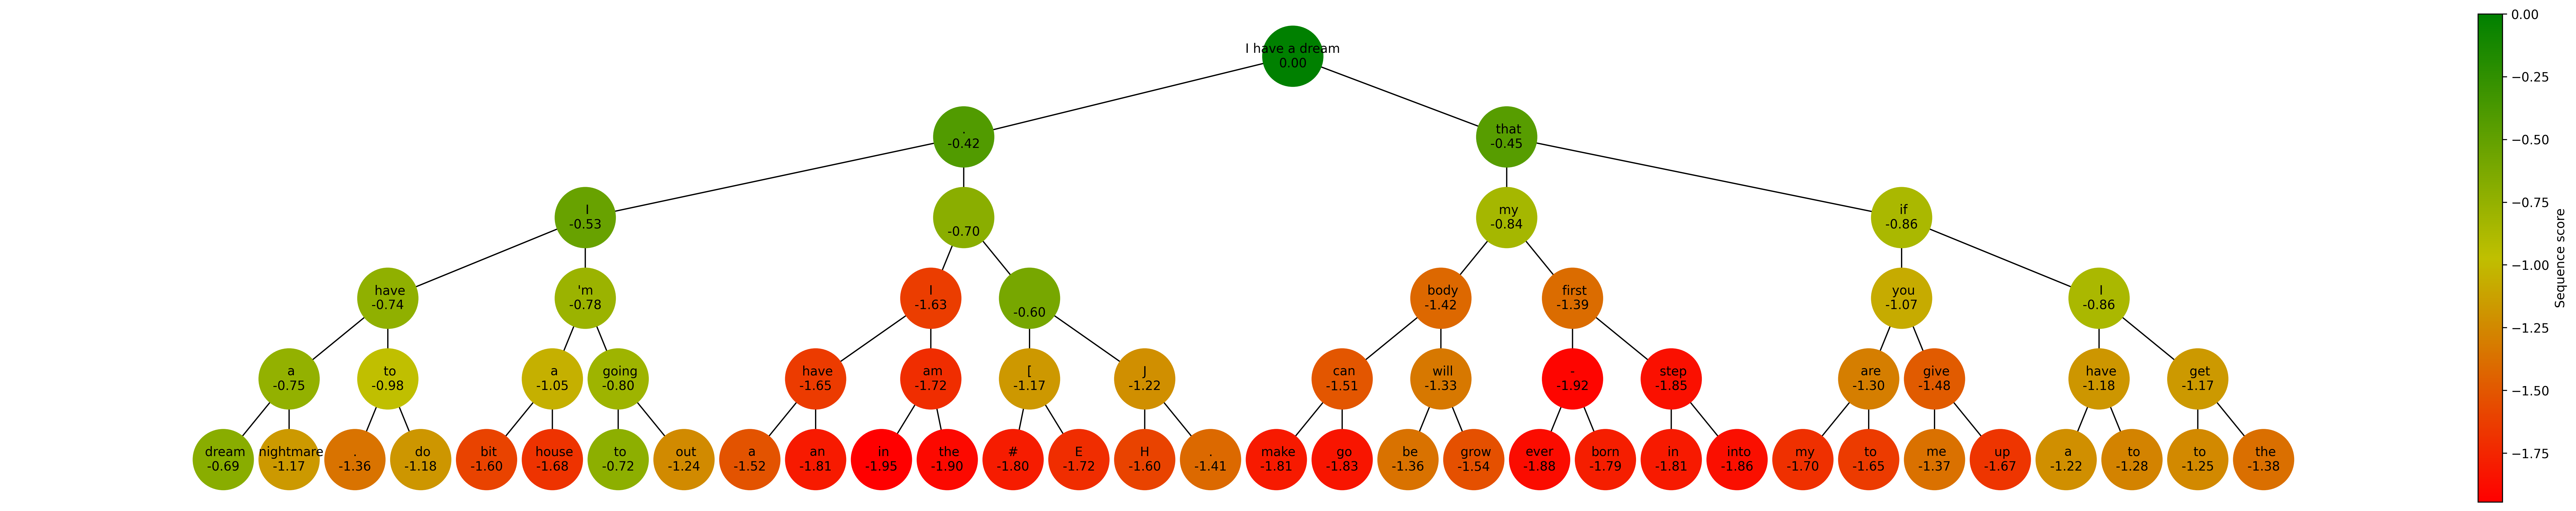

In [15]:
# Grafica
plot_graph(graph, length, beams, 'sequence')